# House Prices: Advanced Regression Techniques
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

## Load data

In [1]:
import pandas as pd

df = pd.read_csv('data/train.csv')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Feature Engineering

### Check not number columns 

In [2]:
not_number_columns = df.columns[df.dtypes == object]
not_number_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [3]:
print("Number of not number columns:", not_number_columns.size)

Number of not number columns: 43


### Map them to N-1 binary columns

Calculate how many unique values has each not number column

In [4]:
number_of_new_columns = 0
for col_name in not_number_columns:
    nunique = df[col_name].nunique()
    number_of_new_columns += nunique-1
    print(col_name, " - ", nunique)

print("\nNew columns:", number_of_new_columns)

MSZoning  -  5
Street  -  2
Alley  -  2
LotShape  -  4
LandContour  -  4
Utilities  -  2
LotConfig  -  5
LandSlope  -  3
Neighborhood  -  25
Condition1  -  9
Condition2  -  8
BldgType  -  5
HouseStyle  -  8
RoofStyle  -  6
RoofMatl  -  8
Exterior1st  -  15
Exterior2nd  -  16
MasVnrType  -  4
ExterQual  -  4
ExterCond  -  5
Foundation  -  6
BsmtQual  -  4
BsmtCond  -  4
BsmtExposure  -  4
BsmtFinType1  -  6
BsmtFinType2  -  6
Heating  -  6
HeatingQC  -  5
CentralAir  -  2
Electrical  -  5
KitchenQual  -  4
Functional  -  7
FireplaceQu  -  5
GarageType  -  6
GarageFinish  -  3
GarageQual  -  5
GarageCond  -  5
PavedDrive  -  3
PoolQC  -  3
Fence  -  4
MiscFeature  -  4
SaleType  -  9
SaleCondition  -  6

New columns: 209


Not looks good. If we use map them to N-1 binary columns, we will have a new 209 columns and 290 features, but we try it...

In [5]:
df = pd.get_dummies(df)

### Convert all NaN values to 0

In [6]:
df = df.fillna(0)

### Convert float64 column type to float32
SVM doesn't support float64, so we need change it to float32

In [7]:
import numpy as np

float64_columns = df.columns[df.dtypes == np.float64]
float64_columns

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [8]:
for col_name in float64_columns:
    df[col_name] = df[col_name].astype(np.float32)

In [9]:
print("Number of rows:", df.shape[0])
print("Number of features:", df.shape[1])

Number of rows: 1460
Number of features: 290


The data set contains 290 source features and only 1460 examples. The ratio features to examples aren't so good, so the plan is the limit of the features, maybe some features can be omitted. Firstly start with a genetic algorithm for select features and nextly use SVM algorithm.

## Split data 
Test data frame - 20%
Train data frame - 80%

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)

In [11]:
X_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

X_test = test_df.drop(['SalePrice'], axis=1)
y_test = test_df['SalePrice']

print("Number of training samples: ", X_train.shape[0])
print("Number of test samples: ", X_test.shape[0])

Number of training samples:  1168
Number of test samples:  292


## Support Vector Machine Algorithm
Before start working with a genetic algorithm, we need to try to find the best hyperparameters for SVM and all features

### Try find the best hyperparameters

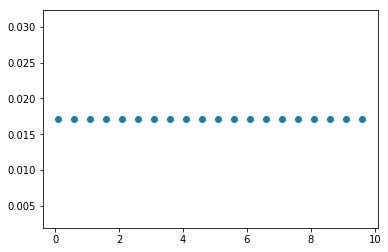

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import svm

results = []
c_values = []
for c in np.arange(0.1, 10.0, 0.5):
    model = svm.SVC(gamma='auto', C=c)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results.append(score)
    c_values.append(c)
    
plt.scatter(x=c_values, y=results)

Interestingly, it seems that regardless of parameter C, SVM can not deal with data where we have too few examples in relation to the number of features. Let's hope that the genetic algorithm will handle it.

### Prepare function for support SVM in GA
GA preparing list of the columns which should be used for training (and test), so we need to create a function which will contain an array with true/false (should be included or not) and length the same as a number of features.

In [13]:
def trainSVMModel(X_train, y_train, X_test, y_test, columns_idx):
    all_columns = X_train.columns
    selected_columns = [x for x, y in zip(all_columns, columns_idx) if y]
    X_train = X_train[selected_columns]
    X_test = X_test[selected_columns]
        
    model = svm.SVC(gamma='auto', C=0.1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

Just for test

In [14]:
columns_idx = np.random.choice(a=[False, True], size=(289))
score = trainSVMModel(X_train, y_train, X_test, y_test, columns_idx)

print("Number of random selected columns:", columns_idx.sum())
print("Score:", score)

Number of random selected columns: 142
Score: 0.017123287671232876
